#### **This Notebook Evaluates the Optimum Cleaning, Model and PageRank Filtering Parameters along with Forward Feature Selection.**

The parameters were tuned using Optuna to maximise **accuracy**.

Import Libraries

In [1]:
import sys
sys.path.append('..')  # Adds the parent directory to the path so Python can find the `Cleaning_and_Evaluation` package
from Cleaning_and_Evaluation import *
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold, cross_validate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

Read the spectral data

You will need to run [PageRank_Filter_Before_Clean.ipynb](../Outlier_Detection/PageRank_Filter_Before_Clean.ipynb) if you haven't already to create this file.

In [2]:
df = pd.read_csv("../data/400-1800_with_raw_scaled_surface_pagerank.csv")
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.610024
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.610024
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.610024
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.610024
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.610024
...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,1.201164
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,1.201164
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,1.201164
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,1.201164


>##### **Select the parameters found by Optuna then clean the spectra**

The spectra before cleaning.

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

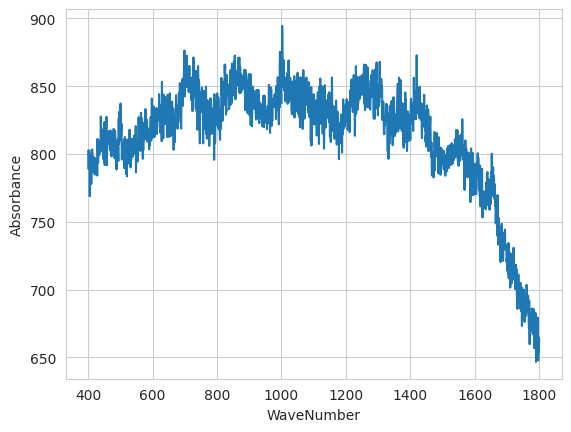

In [3]:
sample = df[df['SpecID'] == "201210-2-08"]
sns.set_style('whitegrid')
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

In [4]:
# Optuna PageRank Parameters
pagerank_cutoff = 0.926659530655764

cleaning_params = {
    'despike': False,
    'baseline_correct': True,
    'smoothing': True,
    'scaling': 'snv',
    'lam': 10**10,
    'p': 0.057,
    'window_size': 77,
    'poly_order': 5
}

# Model Parameters
model = ExtraTreesClassifier(random_state=1234, criterion='gini', max_depth=None, n_estimators=58)

spectra_cleaning(df, **cleaning_params)

df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank
0,201210-1-00,293,400.22778,-0.745287,201210-1,Normal,0.610024
1,201210-1-00,294,400.91116,-0.763910,201210-1,Normal,0.610024
2,201210-1-00,295,401.59454,-0.779497,201210-1,Normal,0.610024
3,201210-1-00,296,402.27789,-0.792336,201210-1,Normal,0.610024
4,201210-1-00,297,402.96127,-0.802699,201210-1,Normal,0.610024
...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,-2.099417,210526-3,Hyperglycemia,1.201164
6239201,210526-3-09,2338,1797.72200,-2.105805,210526-3,Hyperglycemia,1.201164
6239202,210526-3-09,2339,1798.40550,-2.115501,210526-3,Hyperglycemia,1.201164
6239203,210526-3-09,2340,1799.08890,-2.129001,210526-3,Hyperglycemia,1.201164


The spectra after cleaning.

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

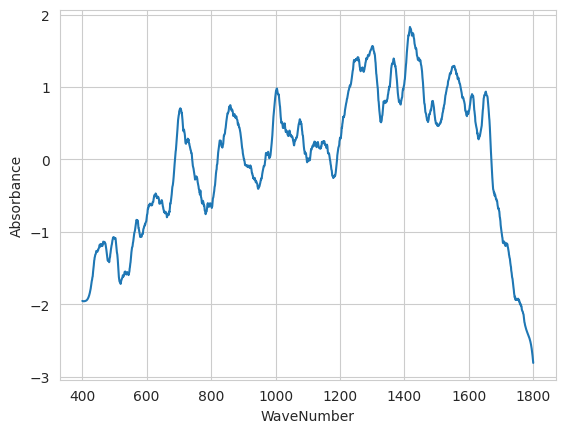

In [5]:
sample = df[df['SpecID'] == "201210-2-08"]
sns.set_style('whitegrid')
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

---

>##### **Filter the Spectra by Surface PageRank**

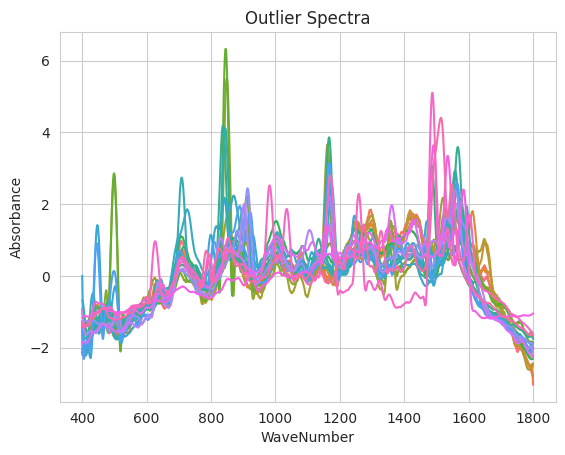

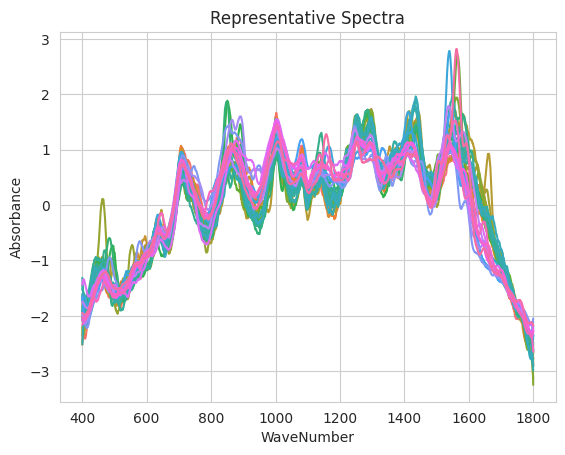

In [6]:
surface = df[df['SurID'] == "201210-2"]
remaining_spectra = surface[surface['PageRank'] > pagerank_cutoff]
outlier_spectra = surface[surface['PageRank'] < pagerank_cutoff]

sns.lineplot(x="WaveNumber", y="Absorbance", data=outlier_spectra, hue='SpecID', legend=False)
plt.title('Outlier Spectra')
plt.show()

plt.title('Representative Spectra')
sns.lineplot(x="WaveNumber", y="Absorbance", data=remaining_spectra, hue='SpecID', legend=False)
plt.show()

In [7]:
df = df[df['PageRank'] > pagerank_cutoff]

---

>##### **Select the Most Effective Features**

In [8]:
selected_features_df = pd.read_csv("../data/best_accuracy_features_selection.csv", index_col=0)
selected_features_df

,WaveNumber
0,482.91571
1,518.45105
2,521.18451
3,552.61957
4,558.08655
5,646.92480
6,661.27563
7,748.74713
8,777.44873
9,783.59906


**Check the proportion of the selected features that are in the signifcant ranges from the thesis**

In [9]:
thesis_wavenumbers = pd.read_csv("../data/thesis_wavenumbers.csv", index_col=0)
thesis_wavenumbers

,WaveNumber
296,402.27789
297,402.96127
298,403.64465
299,404.32803
300,405.01138
...,...
2124,1651.48060
2125,1652.16410
2126,1652.84740
2127,1653.53080


In [10]:
print(f"Proportion of the selected features within the significant ranges: {selected_features_df['WaveNumber'].isin(thesis_wavenumbers['WaveNumber']).sum()/len(selected_features_df):.4f}")

Proportion of the selected features within the significant ranges: 0.7000


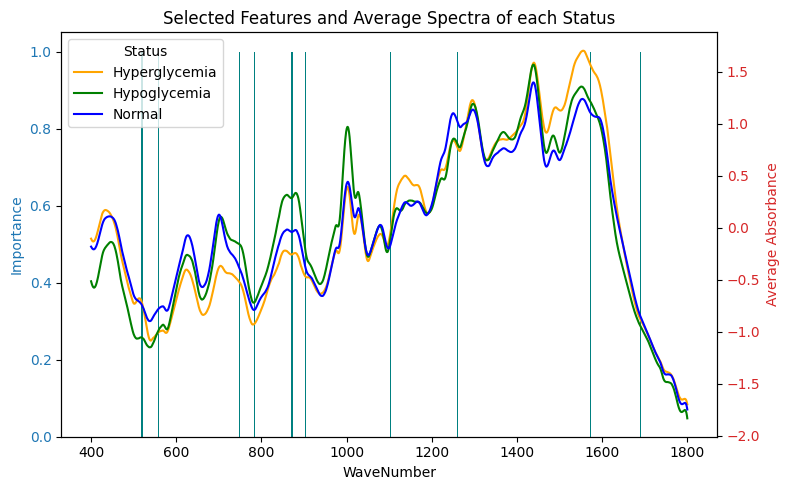

In [11]:
import matplotlib.style as style

# Use the default Matplotlib style
style.use('default')

# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot the bar plot on the first axis for Feature Importance
colors = ['teal'] * len(selected_features_df['WaveNumber'])
ax1.bar(selected_features_df['WaveNumber'], 1, color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Selected Features and Average Spectra of each Status')

# # Show the plot
plt.tight_layout()
plt.show()

Drop the unselected wavenumbers.

In [12]:
df = df[df['WaveNumber'].isin(selected_features_df['WaveNumber'])]
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank
4219,201210-1-02,414,482.91571,0.273240,201210-1,Normal,0.961147
4271,201210-1-02,466,518.45105,-0.466584,201210-1,Normal,0.961147
4275,201210-1-02,470,521.18451,-0.523698,201210-1,Normal,0.961147
4321,201210-1-02,516,552.61957,-0.585700,201210-1,Normal,0.961147
4329,201210-1-02,524,558.08655,-0.588960,201210-1,Normal,0.961147
...,...,...,...,...,...,...,...
6238956,210526-3-09,2093,1630.29610,-0.438617,210526-3,Hyperglycemia,1.201164
6238962,210526-3-09,2099,1634.39640,-0.578000,210526-3,Hyperglycemia,1.201164
6238980,210526-3-09,2117,1646.69700,-0.701081,210526-3,Hyperglycemia,1.201164
6239013,210526-3-09,2150,1669.24830,-1.050655,210526-3,Hyperglycemia,1.201164


---

>##### **Dataset Description**

In [13]:
print(f"Number of remaining samples: {len(df.groupby('SpecID'))}")

Number of remaining samples: 1734


In [14]:
print("Number of Samples by Status")
df.groupby('Status')['SpecID'].nunique()

Number of Samples by Status


Status
Hyperglycemia    491
Hypoglycemia     636
Normal           607
Name: SpecID, dtype: int64

In [15]:
print("Number of Surfaces by Status")
df.groupby('Status')['SurID'].nunique()

Number of Surfaces by Status


Status
Hyperglycemia    19
Hypoglycemia     22
Normal           22
Name: SurID, dtype: int64

---

>##### **Evaluate the Model**

In [16]:
def evaluate_model(df, model):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    # Cross Validate
    scores = cross_validate(model, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)

    # Displaying the results
    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [17]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

evaluate_model(wavelength_df, model)

ExtraTreesClassifier Cross-Validation Accuracy: 0.7595 +/- 0.0748
ExtraTreesClassifier Cross-Validation Precision: 0.6750 +/- 0.1187
ExtraTreesClassifier Cross-Validation Recall: 0.7078 +/- 0.1396
ExtraTreesClassifier Cross-Validation F1-Score: 0.6751 +/- 0.1263


/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---

>##### **Evaluate the Model by Class**

In [18]:
def evaluate_model_by_class(df, model):
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Get unique class names
    class_names = y.unique()
    
    cv = GroupKFold(n_splits=10)

    # Lists to store the metrics by class
    accuracies = []
    precisions = [[] for _ in class_names]
    recalls = [[] for _ in class_names]
    f1_scores = [[] for _ in class_names]

    # Iterate over the splits
    for train_idx, test_idx in cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, zero_division=0, labels=class_names)
        for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
            precisions[i].append(p)
            recalls[i].append(r)
            f1_scores[i].append(f)

    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {np.mean(accuracies):.4f} +/- {np.std(accuracies):.4f}\n")
    for i, class_name in enumerate(class_names):
        print(f"{class_name} Precision: {np.mean(precisions[i]):.4f} +/- {np.std(precisions[i]):.4f}")
        print(f"{class_name} Recall: {np.mean(recalls[i]):.4f} +/- {np.std(recalls[i]):.4f}")
        print(f"{class_name} F1-Score: {np.mean(f1_scores[i]):.4f} +/- {np.std(f1_scores[i]):.4f}\n")

In [19]:
evaluate_model_by_class(wavelength_df, model)

ExtraTreesClassifier Cross-Validation Accuracy: 0.7595 +/- 0.0748

Normal Precision: 0.6396 +/- 0.3165
Normal Recall: 0.5735 +/- 0.2957
Normal F1-Score: 0.5907 +/- 0.2960

Hyperglycemia Precision: 0.6737 +/- 0.1705
Hyperglycemia Recall: 0.7758 +/- 0.1333
Hyperglycemia F1-Score: 0.7097 +/- 0.1247

Hypoglycemia Precision: 0.7118 +/- 0.2677
Hypoglycemia Recall: 0.7741 +/- 0.2879
Hypoglycemia F1-Score: 0.7250 +/- 0.2478



---

>##### **Use Spectra Predictions to Predict the Surface**

A Surface is classified as the most predicted status of its samples.

In [20]:
def evaluate_and_predict_surface_status(df, model):
    
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # DataFrame to store the actual and predicted status for each spectrum
    predictions_df = pd.DataFrame(columns=['SurID', 'ActualStatus', 'PredictedStatus'])

    # Iterating over each fold
    for train_index, test_index in cv.split(X, y, groups=groups):
        # Splitting the dataset into the current train and test set
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        groups_test = groups.iloc[test_index]
        
        # Fitting the model on the training set
        model.fit(X_train, y_train)

        # Predicting the status for the test set
        y_pred = model.predict(X_test)

        # Appending the SurID, actual, and predicted status to the predictions DataFrame
        fold_predictions = pd.DataFrame({
            'SurID': groups_test.values,
            'ActualStatus': y_test.values,
            'PredictedStatus': y_pred
        })

        predictions_df = pd.concat([predictions_df, fold_predictions], ignore_index=True)

    # Return the most common prediction of each spectra within the surface
    return predictions_df.groupby('SurID').agg(lambda x: x.mode()[0]).reset_index()

In [21]:
surface_predictions = evaluate_and_predict_surface_status(wavelength_df, model)
surface_predictions

,SurID,ActualStatus,PredictedStatus
0,201210-1,Normal,Normal
1,201210-2,Normal,Hypoglycemia
2,210114-1,Normal,Normal
3,210114-2,Normal,Normal
4,210120-1,Hyperglycemia,Hyperglycemia
...,...,...,...
58,210519-3,Hyperglycemia,Hyperglycemia
59,210524-1,Hypoglycemia,Hypoglycemia
60,210526-1,Hyperglycemia,Hyperglycemia
61,210526-2,Hyperglycemia,Hyperglycemia


In [22]:
print(classification_report(surface_predictions['ActualStatus'], surface_predictions['PredictedStatus'], digits=4))

               precision    recall  f1-score   support

Hyperglycemia     0.7917    1.0000    0.8837        19
 Hypoglycemia     0.8261    0.8636    0.8444        22
       Normal     1.0000    0.7273    0.8421        22

     accuracy                         0.8571        63
    macro avg     0.8726    0.8636    0.8568        63
 weighted avg     0.8764    0.8571    0.8555        63

